In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/edsa-movie-recommendation-challenge/sample_submission.csv
/kaggle/input/edsa-movie-recommendation-challenge/movies.csv
/kaggle/input/edsa-movie-recommendation-challenge/imdb_data.csv
/kaggle/input/edsa-movie-recommendation-challenge/genome_tags.csv
/kaggle/input/edsa-movie-recommendation-challenge/genome_scores.csv
/kaggle/input/edsa-movie-recommendation-challenge/train.csv
/kaggle/input/edsa-movie-recommendation-challenge/test.csv
/kaggle/input/edsa-movie-recommendation-challenge/tags.csv
/kaggle/input/edsa-movie-recommendation-challenge/links.csv


# <center>EDSA Movie Recommendation</center>
---

<div style = 'text-align: center'><img src = 'https://hd-report.com/wp-content/uploads/2019/07/google-play-4k-uhd-grid-2019-1280px.jpg' width = 800 height = 600></img></div>
<br></br>


## Content
---
* [Introduction](#introduction)
* [Import Packages](#import-pack)
* [Import Data](#import-data)
* [Pre-processing](#pre-process)
* [Exploratory Data Analysis](#eda)
* [Making a Movie Recommendation Model](#model)
* [Conclusion](#conclusion)

<a id="introduction"></a>
# **Introduction**
---
In today’s technology driven world, recommender systems are socially and economically critical for ensuring that individuals can make appropriate choices surrounding the content they engage with on a daily basis. One application where this is especially true surrounds movie content recommendations; where intelligent algorithms can help viewers find great titles from tens of thousands of options.

The task is to construct a recommendation algorithm based on content or collaborative filtering, capable of accurately predicting how a user will rate a movie they have not yet viewed based on their historical preferences.

Providing an accurate and robust solution to this challenge has immense economic potential, with users of the system being exposed to content they would like to view or purchase - generating revenue and platform affinity.

There are two broad groups of approaches for doing this task: collaborative filtering methods and content-based methods.

collaborative filtering — based on user rating and consumption to group similar users together, then to recommend products/services to users

content-based filters — to make recommendations based on similar products/services according to their attributes.


<a id="import-pack"></a>
# **Import Packages**
---
Import neccessary packages required to perform tasks.

In [ ]:
import sys

# Packages for data processing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Packages for visualization
from plotly.offline import init_notebook_mode
import plotly.graph_objects as go

# Packages for modeling
from surprise import Reader
from surprise import Dataset
from surprise import KNNWithMeans
from surprise import KNNBasic
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
import heapq

# Packages for model evaluation
from surprise.accuracy import rmse

# Package to suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Packages for saving models
import pickle

init_notebook_mode(connected = True)

<a id="import-data"></a>
# **Import Data**
---
* Firstly, we will import the data
* Preview the first five rows of each dataset
* See if any dataset contains missing/null values

In [ ]:
df_movies = pd.read_csv('/kaggle/input/edsa-movie-recommendation-challenge/movies.csv')
df_imdb = pd.read_csv('/kaggle/input/edsa-movie-recommendation-challenge/imdb_data.csv')
df_train = pd.read_csv('/kaggle/input/edsa-movie-recommendation-challenge/train.csv')
df_test = pd.read_csv('/kaggle/input/edsa-movie-recommendation-challenge/test.csv')
df_links = pd.read_csv('/kaggle/input/edsa-movie-recommendation-challenge/links.csv')

### Movies Dataset
---
**Contains the following features:**
* **movieId:** an unique ID for each movie
* **title:** the title for each movie
* **genres:** containing more than one genre per movie 

In [ ]:
df_movies.head()

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy

In [ ]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


**Observation:**

* Contains no null values
* Has 62423 rows and 3 columns

### IMDB Dataset
---
**Contains the following features:**
* **moviesId:** an unique ID for each movie
* **title_cast:** names for multiple actors who played in the movie
* **director:** director of the movie
* **runtime:** length of the movie in minutes
* **budget:** amount of money used to produce the movie
* **plot_keywords:** keywords that describes the plot of the movie

In [ ]:
df_imdb.head()

movieId                                         title_cast  \
0        1  Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...   
1        2  Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...   
2        3  Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...   
3        4  Whitney Houston|Angela Bassett|Loretta Devine|...   
4        5  Steve Martin|Diane Keaton|Martin Short|Kimberl...   

              director  runtime       budget  \
0        John Lasseter     81.0  $30,000,000   
1   Jonathan Hensleigh    104.0  $65,000,000   
2  Mark Steven Johnson    101.0  $25,000,000   
3       Terry McMillan    124.0  $16,000,000   
4       Albert Hackett    106.0  $30,000,000   

                                       plot_keywords  
0                   toy|rivalry|cowboy|cgi animation  
1                   board game|adventurer|fight|game  
2                         boat|lake|neighbor|rivalry  
3  black american|husband wife relationship|betra...  
4                    fatherhood|doberman|dog|mansion

In [ ]:
df_imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movieId        27278 non-null  int64  
 1   title_cast     17210 non-null  object 
 2   director       17404 non-null  object 
 3   runtime        15189 non-null  float64
 4   budget         7906 non-null   object 
 5   plot_keywords  16200 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 1.2+ MB


**Observation:**

* Contains null values in the **title_cast**, **director**, **runtime**, **budget** and **plot_keywords** columns
* Has 27278 rows and 6 columns

### Train Dataset
---
**Contains the following features:**
* **userId:** ID for each user
* **movieId:** ID for each movie
* **rating:** rating for each movie
* **timestamp:** date and time represented in seconds

In [ ]:
df_train.head()

userId  movieId  rating   timestamp
0    5163    57669     4.0  1518349992
1  106343        5     4.5  1206238739
2  146790     5459     5.0  1076215539
3  106362    32296     2.0  1423042565
4    9041      366     3.0   833375837

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000038 entries, 0 to 10000037
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 305.2 MB


In [ ]:
df_train.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

**Observation:**

* Contains no null values
* Has 10000038 rows and 4 columns
* Timestamp has a data type of `object` which will be changed going forward.

### Test Dataset
---
**Contains the following features:**
* **userId:** ID for each user
* **movieId:** ID for each movie

In [ ]:
df_test.head()

userId  movieId
0       1     2011
1       1     4144
2       1     5767
3       1     6711
4       1     7318

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000019 entries, 0 to 5000018
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   userId   int64
 1   movieId  int64
dtypes: int64(2)
memory usage: 76.3 MB


In [ ]:
df_test.isnull().sum()

userId     0
movieId    0
dtype: int64

**Observation:**

* Contains no null values
* Has 5000019 rows and 2 columns
* The `info()` method wasn't any help in displaying null values therefore we used the `isnull()` and `sum()` methods to see if each columns contains null values

### Links Dataset
---
**Contains the following features:**
* **movieId:** ID for each movie
* **imdbId:** imdb ID for each movie
* **tmdbID:** The Movie Database ID for each movie

In [ ]:
df_links.head()

movieId  imdbId   tmdbId
0        1  114709    862.0
1        2  113497   8844.0
2        3  113228  15602.0
3        4  114885  31357.0
4        5  113041  11862.0

In [ ]:
df_links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  62423 non-null  int64  
 1   imdbId   62423 non-null  int64  
 2   tmdbId   62316 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 1.4 MB


**Observation:**

* Contains null values in the **tmdbID** column
* Has 62423 rows and 3 columns

<a id="pre-process"></a>
# Pre-Processing
---

#### Memory Reduction
---
Memory reduction can be performed by change each column to a data type that is best suited for the range of values it contains.

**What can be caused without memory reduction?**

This causes a large amount of memory to be placed in reserves for each observation which leads to memory depletion and putting your machine in an unstable state.

**Columns that will be observed:**
* All columns contain `int64` and `float64` data types.
* `timestamp` in the Train DataFrame has an `object` datatype which needs to be converted.

Firstly, we need to get the maximum value in each column to see which data type suits it best.

In [ ]:
print('---Movies Data Set---')
print(df_movies.max(numeric_only = True))
print('\n---IMDB Data Set---')
print(df_imdb.max(numeric_only = True))
print('\n---Train Data Set---')
print(df_train.max(numeric_only = True))
print('\n---Test Data Set---')
print(df_test.max(numeric_only = True))
print('\n---Links Data Set---')
print(df_links.max(numeric_only = True))

---Movies Data Set---
movieId    209171
dtype: int64

---IMDB Data Set---
movieId    131262.0
runtime       877.0
dtype: float64

---Train Data Set---
userId       1.625410e+05
movieId      2.091710e+05
rating       5.000000e+00
timestamp    1.574328e+09
dtype: float64

---Test Data Set---
userId     162541
movieId    209163
dtype: int64

---Links Data Set---
movieId      209171.0
imdbId     11170942.0
tmdbId       646282.0
dtype: float64


### <center>**Data Types**</center>

---
<table>
  <tr>
    <th>Data Type</th>
    <th>Description</th>
  </tr>
  <tr>
    <td>int8</td>
    <td>Byte (-128 to 127)</td>
  </tr>
  <tr>
    <td>int16</td>
    <td>Integer (-32768 to 32767)</td>
  </tr>
  <tr>
    <td>int32</td>
    <td>Integer (-2147483648 to 2147483647)</td>
  </tr>
  <tr>
    <td>int64</td>
    <td>Integer (-9223372036854775808 to 9223372036854775807)</td>
  </tr>
  <tr>
    <td>uint8</td>
    <td>Unsigned integer (0 to 255)</td>
  </tr>
  <tr>
    <td>uint16</td>
    <td>Unsigned integer (0 to 65535)</td>
  </tr>
  <tr>
    <td>uint32</td>
    <td>Unsigned integer (0 to 4294967295)</td>
  </tr>
  <tr>
    <td>uint64</td>
    <td>Unsigned integer (0 to 18446744073709551615)</td>
  </tr>
  <tr>
    <td>float16</td>
    <td>Half precision float: sign bit, 5 bits exponent</td>
  </tr>
  <tr>
    <td>float32</td>
    <td>Single precision float: sign bit, 8 bits exponent</td>
  </tr>
  <tr>
    <td>float64</td>
    <td>Double precision float: sign bit, 11 bits exponent</td>
  </tr>
</table>

Based on our observation on the maximum values in the Train data frame and the different data types, we can assign each column a new datatype.
#### **Data types to be assigned**
**Movies Data Set:**     movieId --> `uint32`

**IMDB Data Set:** movieId --> `uint32`  |  runtime --> `float16`

**Train Data Set:** userId --> `uint32`  |  movieId --> `uint32`  |  rating --> `float16`  |  timestamp --> `uint32`

**Test Data Set:** userId --> `uint32`  |  movieId --> `uint32`

**Links Data Set:** movieId --> `uint`  |  imdbId --> `uint32`  |  tmdbId --> `will be removed`

In [ ]:
# Data Frame sizes before conversion
before_convert = (sys.getsizeof(df_movies) + 
                  sys.getsizeof(df_imdb) + 
                  sys.getsizeof(df_train) + 
                  sys.getsizeof(df_test) + 
                  sys.getsizeof(df_links)) / 1000000

In [ ]:
# Movies DF
df_movies['movieId'] = df_movies['movieId'].astype('uint32')

# IMDB DF
df_imdb['movieId'] = df_imdb['movieId'].astype('uint32')
df_imdb['runtime'] = df_imdb['runtime'].astype('float16')

# Train DF
df_train['movieId'] = df_train['movieId'].astype('uint32')
df_train['userId'] = df_train['userId'].astype('uint32')
df_train['timestamp'] = df_train['timestamp'].astype('uint32')
df_train['rating'] = df_train['rating'].astype('float16')

# Test DF
df_test['movieId'] = df_test['movieId'].astype('uint32')
df_test['userId'] = df_test['userId'].astype('uint32')

# Links DF
df_links['movieId'] = df_links['movieId'].astype('uint32')
df_links['imdbId'] = df_links['imdbId'].astype('uint32')

In [ ]:
# Data Frame sizes after conversion
after_convert = (sys.getsizeof(df_movies) + 
                  sys.getsizeof(df_imdb) + 
                  sys.getsizeof(df_train) + 
                  sys.getsizeof(df_test) + 
                  sys.getsizeof(df_links)) / 1000000

In [ ]:
# Plotly template being used
template = 'plotly_dark'

# Colour being used for all plots
color = '#4590b8'

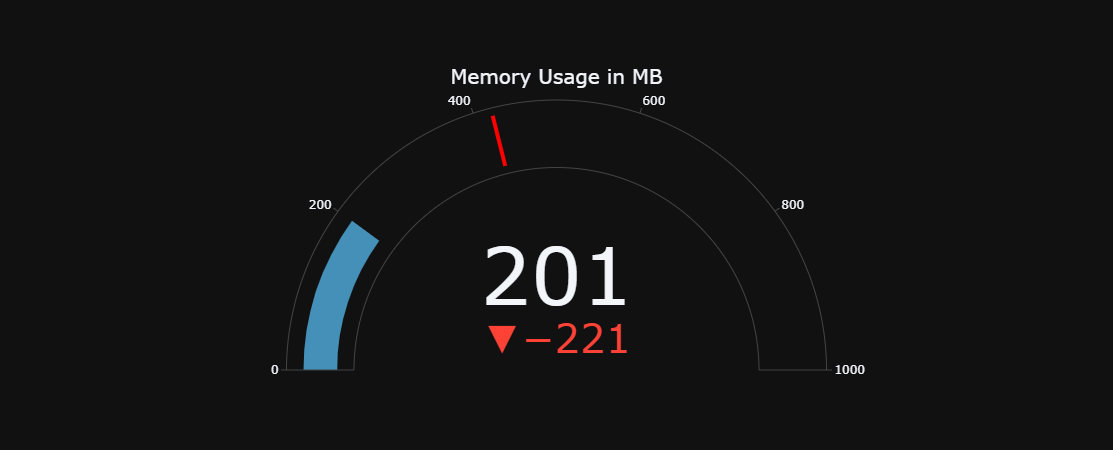

In [ ]:
fig = go.Figure()

fig.add_trace(go.Indicator(
    value = after_convert,
    delta = {'reference': before_convert},
    gauge = {
        'axis': {
            'range': [None, 1000]
        },
        'threshold' : {
            'line': {
                'color': "red", 'width': 4
            }, 
            'thickness': 0.75, 
            'value': before_convert
        }
    },
    mode = "number+delta+gauge",
    title = {'text': "Memory Usage in MB"}))


fig.update_layout(
    template = template)

fig.update_traces(gauge_bar_color = color)

The combined memory usage has been reduced by approximately 221MB. This will make the transfer of data much faster and will reduce the amount of resources needed to process the data.

If the data frames are merged then it will increase the memory usage because of the increase in dimensions / columns. To avoid increasing the amount of resources being used, remove variables that you are no longer using by using `del <variable_name>`.
For example, if you merge the data frames and store it in a new variable then there is no need to keep the individual data frame variables.


--- 
### <center>Further pre-processing will be done when needed</center>

---

<a id="eda"></a>
# **Exploratory Data Analysis**
---

### Most Common Genres
---
We will be observing the frequency of genres. As we saw above, the genres column has multiple genres seperated with a vertical line `|` therefore we first have to split the genres and store them in a list.

In [ ]:
# Splitting the genres
movie_genres = df_movies['genres'].apply(lambda x: x.split('|'))

list_genres = []
for genre_list in movie_genres:
    for genre in genre_list:
        list_genres.append(genre)

# Convert the list into a Series to get value count
list_genres = pd.Series(list_genres)

In [ ]:
def series_to_df(series, column1, column2 = 'total'):
    """
        * Converts series into a count DataFrame
    """
    series_count = series.value_counts()
    series_df = pd.DataFrame(columns = [column1, column2])
    series_df[column1] = list(series_count.index)
    series_df[column2] = series_count.values
    
    return series_df

In [ ]:
genre_df = series_to_df(list_genres, 'genre')

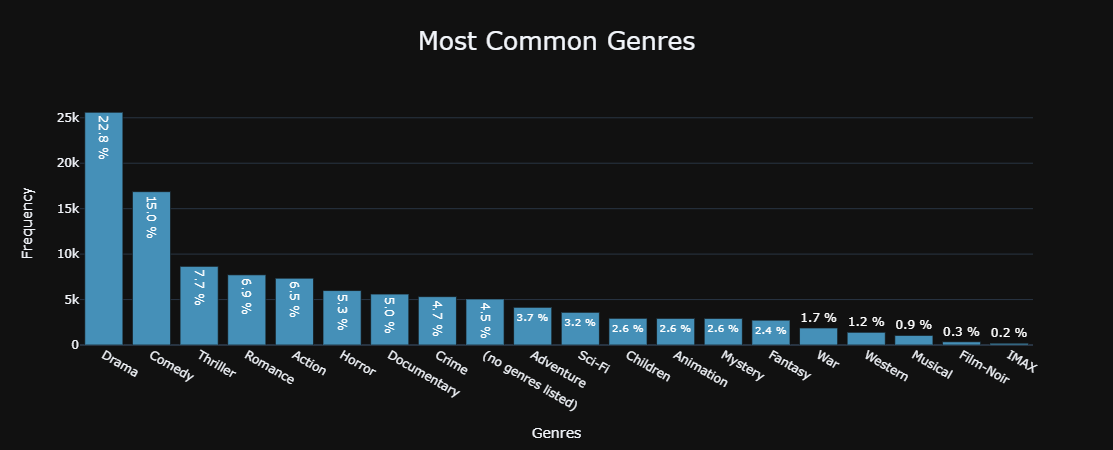

In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x = genre_df['genre'],
    y = genre_df['total'],
    text = ['{:.1f} %'.format((val / genre_df['total'].sum() * 100)) for val in (genre_df['total'])],
    textposition = 'auto',
    textfont = dict(color = '#FFFFFF')
))

fig.update_layout(
    title = {
        'text': 'Most Common Genres',
        'font': {
            'size': 25
        }
    },
    title_x = 0.5,
    template = template
)

fig.update_xaxes(
    title = {
        'text': 'Genres'
    }
)

fig.update_yaxes(
    title = {
        'text': 'Frequency'
    }
)

fig.update_traces(marker_color = color)

<li> <code> Drama </code>, <code> Comedy </code> have a higher occurence in the dataset.

<li> <code> Musical </code>, <code> Film-Noir </code>, <code> IMAX </code> genres have the lowest respectively, they all have an ocurence of under $1 $% 

### Movies analysis
---
**We will be displaying the following figures:**
* Total Number of Movies
* Total Number of Users
* Average Rating for Movies
* Average Runtime for Movies


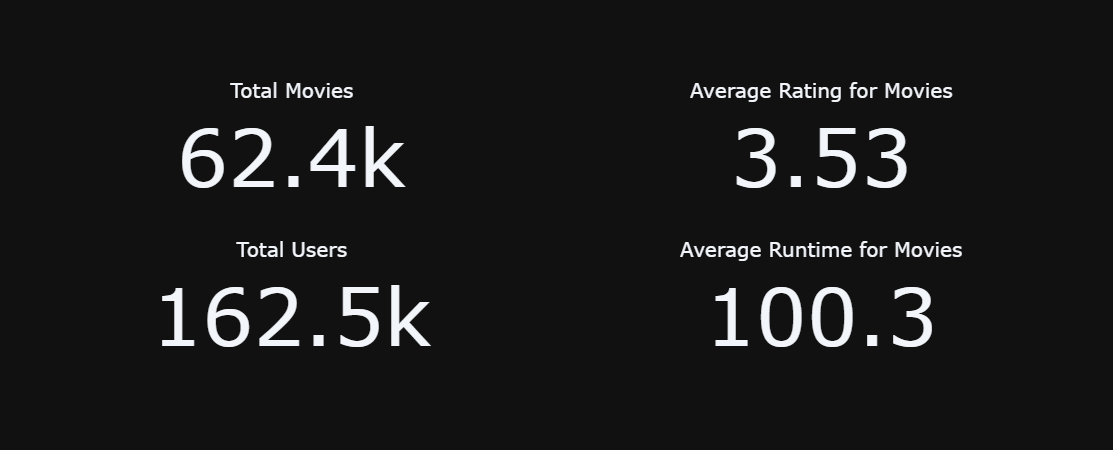

In [ ]:
fig = go.Figure()

fig.add_trace(go.Indicator(
    mode = "number",
    value = df_movies['movieId'].nunique(),
    domain = {'row': 0, 'column': 0}, 
    title = 'Total Movies'))

fig.add_trace(go.Indicator(
    mode = "number",
    value = df_train['userId'].nunique(),
    domain = {'row': 1, 'column': 0}, 
    title = 'Total Users'))


fig.add_trace(go.Indicator(
    mode = "number",
    value = np.mean(np.array(df_train['rating'])),
    domain = {'row': 0, 'column': 1}, 
    title = 'Average Rating for Movies'))

fig.add_trace(go.Indicator(
    mode = "number",
    value = np.mean(np.array(df_imdb['runtime'].dropna())),
    domain = {'row': 1, 'column': 1}, 
    title = 'Average Runtime for Movies'))

fig.update_layout(
    grid = {'rows': 2, 'columns': 2, 'pattern': "independent"}, 
    template = template)

### Rating Distribution
---
We will be looking at how ratings are distributed

In [ ]:
rating_df = series_to_df(df_train['rating'], 'rating')

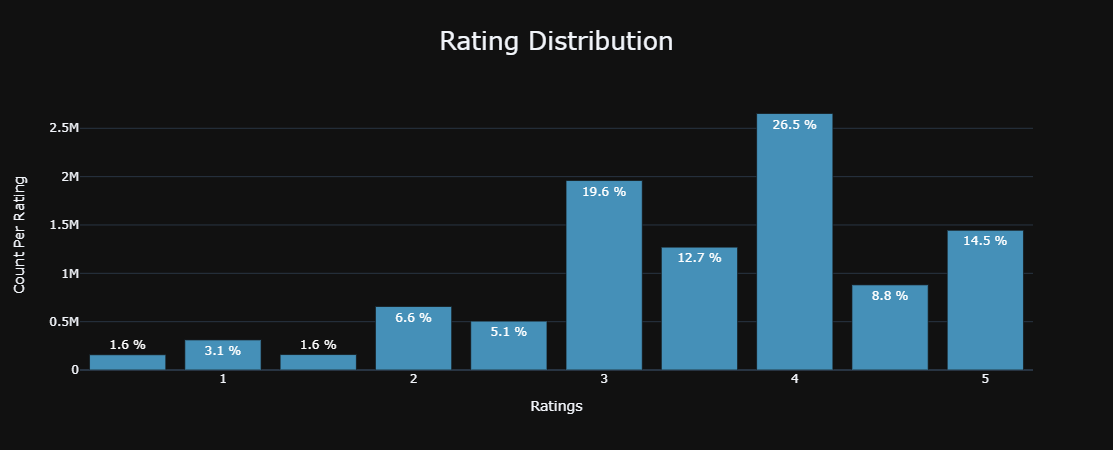

In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x = rating_df['rating'],
    y = rating_df['total'],
    text = ['{:.1f} %'.format((val / rating_df['total'].sum() * 100)) for val in (rating_df['total'])],
    textposition = 'auto',
    textfont = dict(color = '#FFFFFF')
))

fig.update_layout(
    title = {
        'text': 'Rating Distribution',
        'font': {
            'size': 25
        }
    },
    title_x = 0.5,
    template = template
)

fig.update_xaxes(
    title = {
        'text': 'Ratings'
    }
)

fig.update_yaxes(
    title = {
        'text': 'Count Per Rating'
    }
)

fig.update_traces(marker_color = color)

#### Observation:
#### Observation:
* `26.5%` of all ratings is `4` which is the majority.
* The distribution shows a skewness in the positive direction
* Very good quality movies in the dataset, as most of the movies, have been rated between the range from 3 to 5.
* Considering only rating is not the right measure of popularity, as there may be the case where one movie is rated 5 by few users and another rated 4.8 by many users.

### Distribution of the number of ratings per user
---
Knowing that there are so many users, we just can't look at them all. Therefore we will visualise the first 50 users and the total numer of rating for each of them.

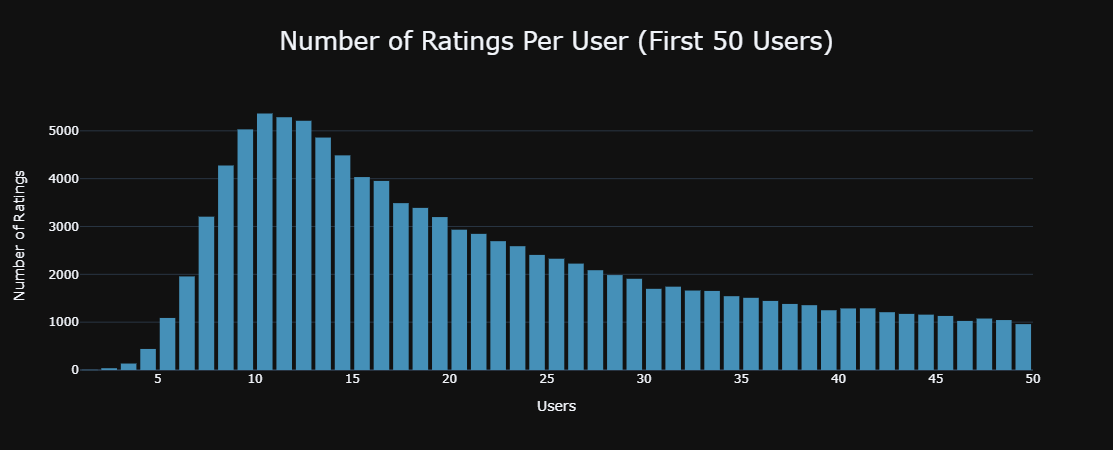

In [ ]:
user_p = df_train.groupby('userId')['rating'].count().clip(upper = 50)
fig = go.Figure()

fig.add_trace(go.Histogram(x = user_p.values,
                     name = 'rating',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 1)))

fig.update_layout(
    title = {
        'text': 'Number of Ratings Per User (First 50 Users)',
        'font': {
            'size': 25
        }
    },
    title_x = 0.5,
    template = template,
    bargap = 0.2
)

fig.update_xaxes(
    title = {
        'text': 'Users'
    }
)

fig.update_yaxes(
    title = {
        'text': 'Number of Ratings'
    }
)

fig.update_traces(marker_color = color)

#### Observation:
It appears that there are users who have rated only a few movies, this implies that not all users are equivalent to suggest movie recommendations to other users. This is only one perspective, we could also view it as movies that only received one or very few ratings. This can be caused by a lack of popularity or received a bad rating by the first user then became overlooked by other users.

### Most Ratings per Movie
---
We will be looking at the top 10 movies with the most total ratings (this is only the total number of ratings given, not the average ratings).

In [ ]:
# Merge the Movies and Train DataFrame to get names of movies
movies_df = df_train.merge(df_movies, how = 'left', on = 'movieId')

In [ ]:
# Get top 10 movies with the most ratings
total_ratings = movies_df.groupby('title')['rating'].count().sort_values(ascending = False)[:10]

# Create a DataFrame for the total ratings
total_ratings_df= pd.DataFrame(columns = ['movies', 'total'])
total_ratings_df['movies'] = list(total_ratings.index)
total_ratings_df['total'] = total_ratings.values

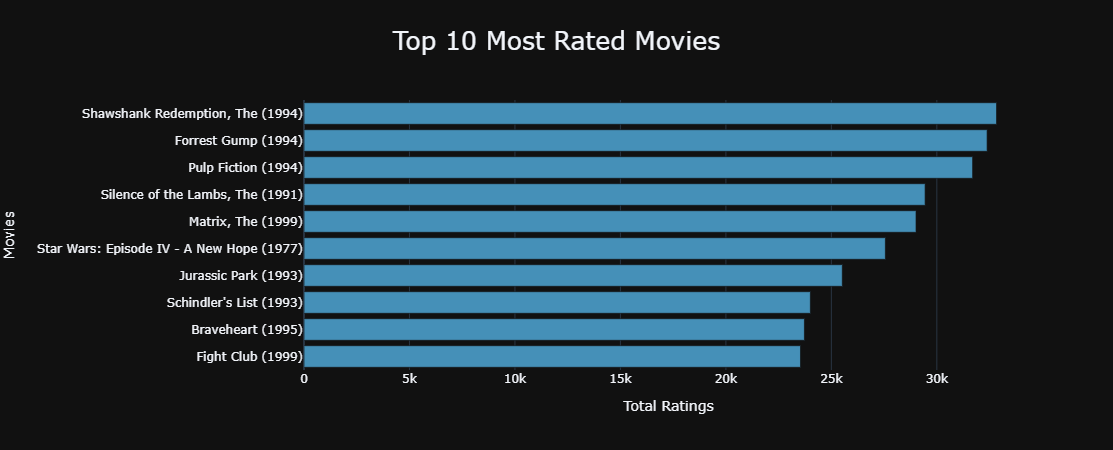

In [ ]:
"""
    * Plotly adds data to plots in a stack manner
    * Data must be in ascending order with the lowest total first
    * This will allow the highest total to appear at the top
"""

movie_p = total_ratings_df.sort_values('total', ascending = True)
fig = go.Figure()

fig.add_trace(go.Bar(x = movie_p['total'],
                     y = movie_p['movies'],
                     orientation = 'h'
                    
                    ))
fig.update_layout(
    title = {
        'text': 'Top 10 Most Rated Movies',
        'font': {
            'size': 25
        }
    },
    title_x = 0.5,
    template = template,
    bargap = 0.2
)

fig.update_xaxes(
    title = {
        'text': 'Total Ratings'
    }
)

fig.update_yaxes(
    title = {
        'text': 'Movies'
    }
)

fig.update_traces(marker_color = color)

#### Observation:
 * The movie with the most ratings is **Shawshank Redemption, The (1994)**, the movie is about a banker who is convicted for the murder of his wife and her lover and is sentenced to two consecutive life sentences at the Shawshank State Prison. This movie is based on **Rita Hayworth and Shawshank Redemption** by Stephen King and it is claimed to be amongs the best movies ever made in World Cinema and applauded by many film critics.
 * **Forrest Gump (1994)** is about a man with a low IQ, recounts the early years of his life when he found himself in the middle of key historical events. This movie has been voted the greatest film character of all time, beating James Bond and Scarlett O'Hara in the process

### Most Average Rated Movie
---
We will be looking at the top 10 movies with the most average rating.

In [ ]:
"""
    * There are movies with only one rating which is impractical to include
    * The threshold being used is 20
    * All movies with a rating total of less than or equal to 20 will be filtered out
"""

min_total_ratings = 20
filter_ = movies_df['movieId'].value_counts() > min_total_ratings
filter_ = filter_[filter_].index.tolist()

df_filtered = movies_df[movies_df['movieId'].isin(filter_)]

In [ ]:
# Get top 10 movies with the most average ratings
avg_ratings = df_filtered.groupby('title')['rating'].mean().sort_values(ascending = False)[:10]

# Create a DataFrame for the avg ratings
avg_ratings_df= pd.DataFrame(columns = ['movies', 'average'])
avg_ratings_df['movies'] = list(avg_ratings.index)
avg_ratings_df['average'] = avg_ratings.values

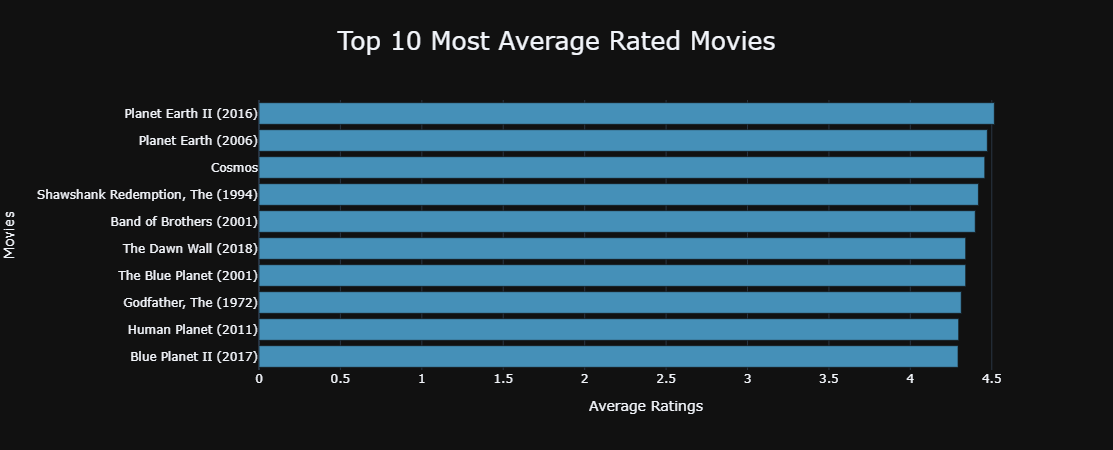

In [ ]:
avg_df = avg_ratings_df.sort_values('average', ascending = True)
fig = go.Figure()

fig.add_trace(go.Bar(x = avg_df['average'],
                     y = avg_df['movies'],
                     orientation = 'h'
                    
                    ))
fig.update_layout(
    title = {
        'text': 'Top 10 Most Average Rated Movies',
        'font': {
            'size': 25
        }
    },
    title_x = 0.5,
    template = template,
    bargap = 0.2
)

fig.update_xaxes(
    title = {
        'text': 'Average Ratings'
    }
)

fig.update_yaxes(
    title = {
        'text': 'Movies'
    }
)

fig.update_traces(marker_color = color)

#### Observation:
* **Planet Earth II** is a British nature documentary series produced by the BBC as a sequel to **Planet Earth**.
* **Cosmos** is an American science documentary television series.

### Number of ratings per year
---
We will be looking at the total number of ratings per year. 

**Note:** This is for the total ratings ever made each year.

In [ ]:
def timestamp_to_date(timestamps):
    """
        * Convert timestamps to dates 
        * Only the year is extracted
        * Get the count for each year
        
        Parameters:
        ===========================
        * timestamps: Series or list containing timestamps
        
        Returns:
        ===========================
        * DataFrame sorted by year
    """
    years = []
    for timestamp in timestamps:
        years.append(pd.Timestamp(timestamp, unit = 's').year)# Convert timestamp datetime and return the year
        
    years = pd.Series(years).value_counts()
    df_years = pd.DataFrame(columns = ['years', 'total'])
    df_years['years'] = list(years.index)
    df_years['total'] = years.values
    
    return df_years.sort_values(by = 'years')

In [ ]:
year_counts = timestamp_to_date(df_train['timestamp'])

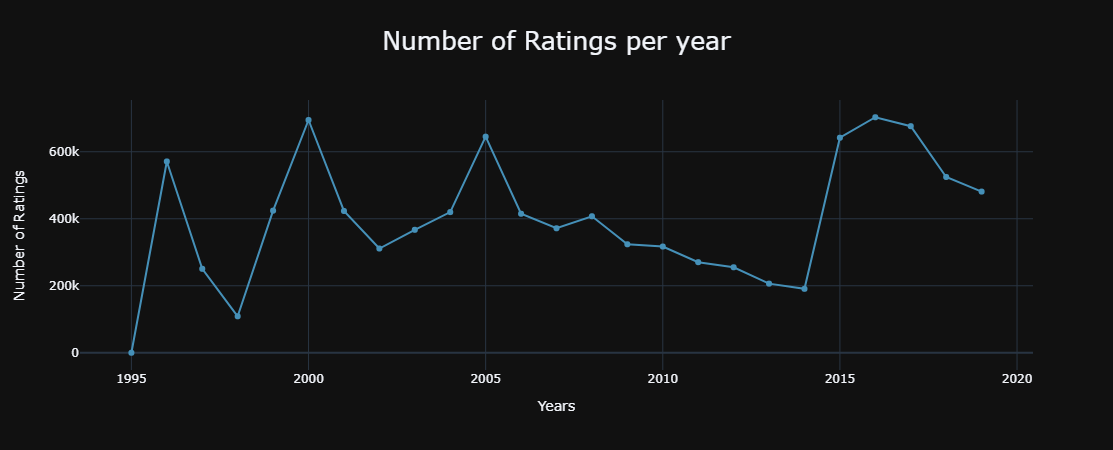

In [ ]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(x = year_counts['years'], 
               y = year_counts['total'], 
               mode='lines+markers'))

fig.update_layout(
    title = {
        'text': 'Number of Ratings per year',
        'font': {
            'size': 25
        }
    },
    title_x = 0.5,
    template = template,
)

fig.update_xaxes(
    title = {
        'text': 'Years'
    }
)

fig.update_yaxes(
    title = {
        'text': 'Number of Ratings'
    }
)

fig.update_traces(marker_color = color)

<blockquote>The most ratings were received in the year 2016 with a total of <b>702 962</b>. As we can see that the year 1998 received the least count of ratings with a total of <b>108 811</b>. After 2014, the count of rating increased tremendously and started declining after 2016.</blockquote>

### Top 10 Actors With Most Movie Appearances
---
We will extracting the top 10 actors with the most movie appearances. 

In [ ]:
# Extract all actors
actors_ = []

for actors in df_imdb['title_cast'].dropna():
    for actor in actors.split('|'):
        actors_.append(actor)

In [ ]:
actors_ = pd.Series(actors_)

actors_df= series_to_df(actors_, 'actors', 'total movies')

In [ ]:
actors_df = actors_df[:10].sort_values('total movies', ascending = True)

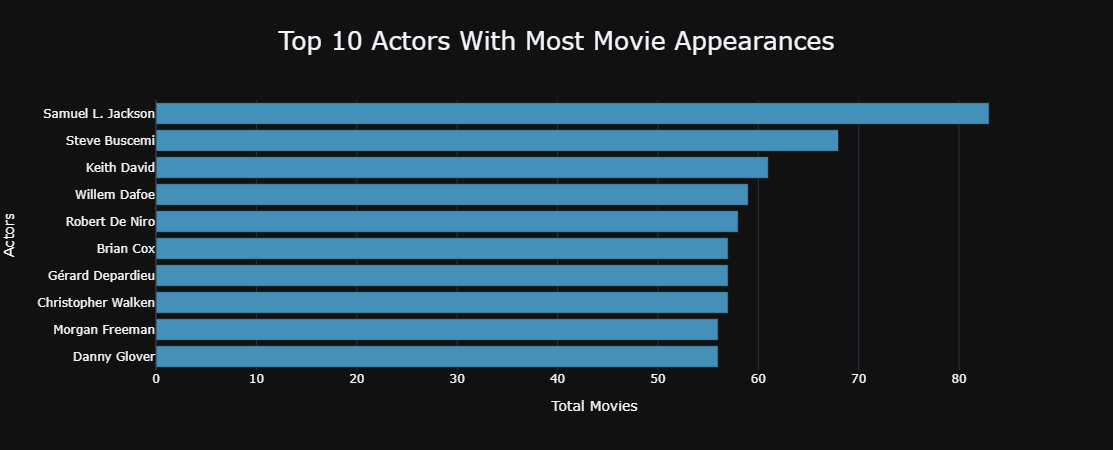

In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(x = actors_df['total movies'],
                     y = actors_df['actors'],
                     orientation = 'h'
                    
                    ))
fig.update_layout(
    title = {
        'text': 'Top 10 Actors With Most Movie Appearances',
        'font': {
            'size': 25
        }
    },
    title_x = 0.5,
    template = template,
    bargap = 0.2
)

fig.update_xaxes(
    title = {
        'text': 'Total Movies'
    }
)

fig.update_yaxes(
    title = {
        'text': 'Actors'
    }
)

fig.update_traces(marker_color = color)

#### Observation:
* **Samuel L. Jackson** shows up, nail his scenes, and then take off, leaving less in-demand collaborators and co-stars to finish the film while he moves on to the next one. This explains why he stars in so many movies.
* **Steve Buscemi** plays in a lot of comedy movies including those with Adam Sandler where he is a regular cast.

### Top 10 Directors with Most Directed Movies
---
We will  be extracting the top 10 directors who directed the most movies.

In [ ]:
directors_ = df_imdb['director'].dropna()

directors_df = series_to_df(directors_, 'directors', 'total movies')

In [ ]:
directors_df = directors_df[1:11].sort_values('total movies', ascending = True)

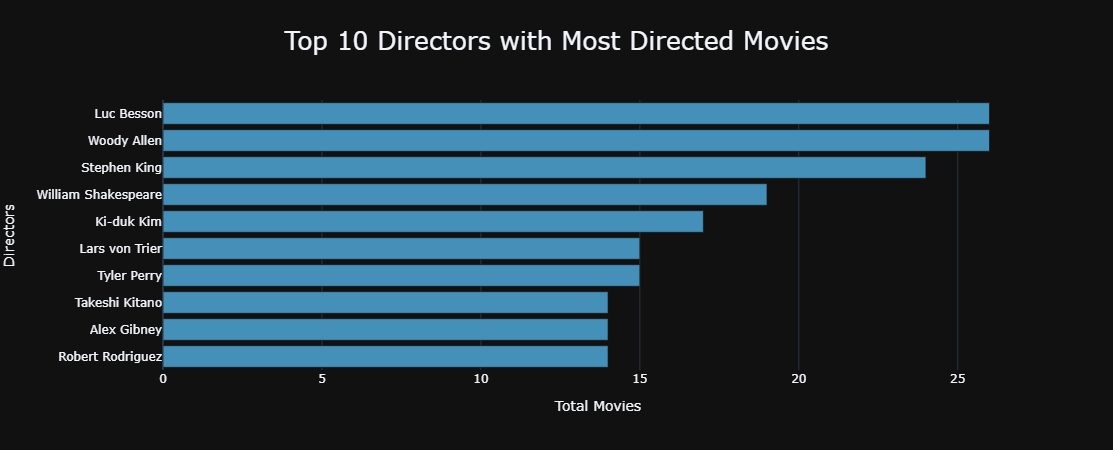

In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(x = directors_df['total movies'],
                     y = directors_df['directors'],
                     orientation = 'h'
                    
                    ))
fig.update_layout(
    title = {
        'text': 'Top 10 Directors with Most Directed Movies',
        'font': {
            'size': 25
        }
    },
    title_x = 0.5,
    template = template,
    bargap = 0.2
)

fig.update_xaxes(
    title = {
        'text': 'Total Movies'
    }
)

fig.update_yaxes(
    title = {
        'text': 'Directors'
    }
)

fig.update_traces(marker_color = color)

#### Observation:
* **Luc Besson** is a French film director, screenwriter, and producer.He won Best Director and Best French Director for his sci-fi action film The Fifth Element (1997). He wrote and directed the 2014 sci-fi action film Lucy and the 2017 space opera film Valerian and the City of a Thousand Planets. As writer, director, or producer, Besson has so far been involved in the creation of more than 50 films.
* **Stephen King** is an author of many books which end up on screen. He is best known for his book and movie I.T.
* **William Shakespeare**'s plays has been credited on 1,500 movies , including those under production but not yet released.

### Top 5 genres (movies) produced per year 
---
Using the top 5 most frequency genres, we will see how frequent movies were created in those genres over time.

In [ ]:
def get_years(df, genre):
    """
        Gets the years of when movies were released in a specific genre
        
        Parameters:
        ===============================================================
        * df: DataFrame 
        * genre: genre to be used as a filter
        
        Return:
        ===============================================================
        * Series containing the years for all movies in the specified genre
        
    """
    genre_filter = df[df['genres'].str.contains(genre)]['title']
    
    years = []
    for title in genre_filter:
        if '(' in title:
            if title[title.index('(') + 1 : title.index(')')].isdigit() and len(str(title[title.index('(') + 1 : title.index(')')])) == 4:
                years.append(title[title.index('(') + 1 : title.index(')')])
            else:
                pass
    return pd.Series(years)

In [ ]:
# Get the years for each genre
drama = get_years(df_movies, 'Drama')
comedy = get_years(df_movies, 'Comedy')
thriller = get_years(df_movies, 'Thriller')
romance = get_years(df_movies, 'Romance')
action = get_years(df_movies, 'Action')

In [ ]:
# Convert into DataFrame with years counts
drama = series_to_df(drama, 'years', 'count').sort_values(by = 'years')
comedy = series_to_df(comedy, 'years', 'count').sort_values(by = 'years')
thriller = series_to_df(thriller, 'years', 'count').sort_values(by = 'years')
romance = series_to_df(romance, 'years', 'count').sort_values(by = 'years')
action = series_to_df(action, 'years', 'count').sort_values(by = 'years')

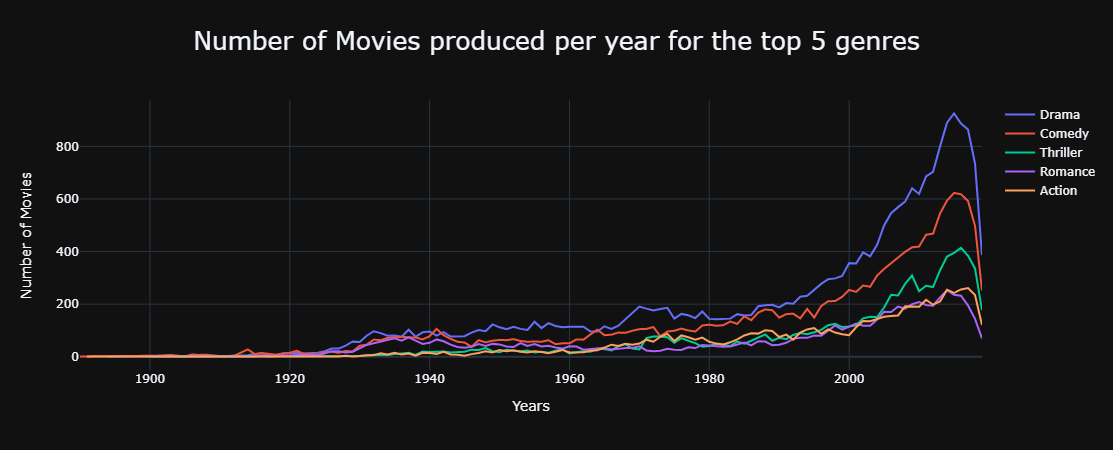

In [ ]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(x = drama['years'].astype('int32'), 
               y = drama['count'], 
               mode='lines', 
               name = 'Drama'))

fig.add_trace(
    go.Scatter(x = comedy['years'].astype('int32'), 
               y = comedy['count'], 
               mode='lines', 
               name = 'Comedy'))


fig.add_trace(
    go.Scatter(x = thriller['years'].astype('int32'), 
               y = thriller['count'], 
               mode='lines', 
               name = 'Thriller'))

fig.add_trace(
    go.Scatter(x = romance['years'].astype('int32'), 
               y = romance['count'], 
               mode='lines', 
               name = 'Romance'))

fig.add_trace(
    go.Scatter(x = action['years'].astype('int32'), 
               y = action['count'], 
               mode='lines', 
               name = 'Action'))

fig.update_layout(
    title = {
        'text': 'Number of Movies produced per year for the top 5 genres',
        'font': {
            'size': 25
        }
    },
    title_x = 0.5,
    template = template
)

fig.update_xaxes(
    title = {
        'text': 'Years'
    }
)

fig.update_yaxes(
    title = {
        'text': 'Number of Movies'
    }
)


#### Observation:
The number of movies produced were extremely low in the early stage of film production, but started increase by approximately 1926. **Drama** showed promise which features stories with high stakes, a lot of conflict and follows a clear defined narrative plot structure. **Comedy** is popular but sometimes the plot can be misleading. Jokes made in comedy movies are sometimes hard for some viewers to get which results in poor reviews. This can lead to abandoning projects or changing to a different genre that can give a clear and entertaining storyline for viewers to enjoy.

<a id="model"></a>
# Make a Movie Recommendation Model
---
* Collaborative Filtering
    * Model Based
    * Memory Based
* Content Based Filtering

## Collaborative Filtering
---
Collaborative Filtering, unlike content-based filtering, doesn’t need anything else except users’ historical preference on a set of items. Because it’s based on historical data, the core assumption here is that the users who have agreed in the past tend to also agree in the future. In terms of user preference, it usually expressed by two categories. Explicit Rating, is a rate given by a user to an item on a sliding scale, like 5 stars for Titanic. This is the most direct feedback from users to show how much they like an item. Implicit Rating, suggests users preference indirectly, such as page views, clicks, purchase records, whether or not listen to a music track, and so on.

<img src = 'https://miro.medium.com/max/1400/1*7uW5hLXztSu_FOmZOWpB6g.png' alt = 'Collaborative Filtering' title = 'Collaborative Filtering'></img>

#### Model based approach

In this approach, CF models are developed using machine learning algorithms to predict user’s rating of unrated items.

In [ ]:
# Filter out movies that were rated less than or equal to 100
min_movie_ratings = 100
filter_movies = df_train['movieId'].value_counts() > min_movie_ratings
filter_movies = filter_movies[filter_movies].index.tolist()

df_new = df_train[(df_train['movieId'].isin(filter_movies))]
print('The original data frame shape:\t{}'.format(df_train.shape))
print('The new data frame shape:\t{}'.format(df_new.shape))

In [ ]:
# Sort by timestamp to get the most recent first
df_demo = df_new.sort_values(by = 'timestamp', ascending = False)

In [ ]:
reader = Reader(rating_scale = (0.5, 5.0))

data = Dataset.load_from_df(df_demo[['userId', 'movieId', 'rating']], reader)

In [ ]:
trainset = data.build_full_trainset()

### SVD
---
SVD is a factorization of a real or complex matrix that generalizes the eigendecomposition, which only exists for square normal matrices, to any m\times n matrix via an extension of the polar decomposition.
<br></br>
<img src = 'https://upload.wikimedia.org/wikipedia/commons/thumb/b/bb/Singular-Value-Decomposition.svg/1200px-Singular-Value-Decomposition.svg.png' width = '500px' height = '500px'></img>

In [ ]:
svd_ = SVD()

In [ ]:
svd_.fit(trainset)

In [ ]:
testset = trainset.build_testset()

In [ ]:
predictions = svd_.test(testset)

In [ ]:
rmse(predictions)

### KNNWithMeans
---
KNNWithMeans is basic collaborative filtering algorithm, taking into account the mean ratings of each user.

In [ ]:
knn_ = KNNWithMeans()

In [ ]:
knn_.fit(trainset)

In [ ]:
knn_pred = knn_.test(testset)

In [ ]:
rmse(knn_pred)

### CoClustering
---
Co-clustering is a collaborative filtering algorithm based on grouping users and items into clusters. 

In [ ]:
coc_ = CoClustering()

In [ ]:
coc_.fit(trainset)

In [ ]:
coc_pred = coc_.test(testset)

In [ ]:
rmse(coc_pred)

### SlopeOne
---
SlopeOne algorithm uses a straightforward simple linear regression model to solve data sparisity problem. Its characterised by  ease to use, accurate recommendation and high computational efficiency.

In [ ]:
slope_ = SlopeOne()

In [ ]:
slope_.fit(trainset)

In [ ]:
slope_pred = slope_.test(testset)

In [ ]:
rmse(slope_pred)

### KNNBasic
---
KNNBasic is a basic collaborative filtering algorithm based on the basic nearest-neighbor technique, which is derived from the basic nearest-neighbor approach.

In [ ]:
knn_basic = KNNBasic()

In [ ]:
knn_basic.fit(trainset)

In [ ]:
knn_basic_pred = knn_basic.test(testset)

In [ ]:
rmse(knn_basic_pred)

#### Model Evaluation
---

In [ ]:
# List of RMSE for the different models
mylist = [['SlopeOne', rmse(slope_pred)], ['CoClustering', rmse(coc_pred)], ['KNNBasic', rmse(knn_basic_pred)],
       ['KNNWithMeans', rmse(knn_pred)], ['SVD', rmse(predictions)]]

# Create a DataFrame for the RMSE
df_RMSE = pd.DataFrame(mylist, columns=['Model', 'RMSE'])
df_RMSE

Model    RMSE
0      SlopeOne  0.7927
1  CoClustering  0.8210
2      KNNBasic  0.7465
3  KNNWithMeans  0.7281
4           SVD  0.5985

It appears that SVD performed the best with a RMSE of 0.5985.

#### Memory based approach:

Memory-Based Collaborative Filtering approaches can be divided into two main sections: user-item filtering and item-item filtering. A user-item filtering takes a particular user, find users that are similar to that user based on similarity of ratings, and recommend items that those similar users liked. In contrast, item-item filtering will take an item, find users who liked that item, and find other items that those users or similar users also liked. It takes items and outputs other items as recommendations.

Item-Item Collaborative Filtering: “Users who liked this item also liked …”
User-Item Collaborative Filtering: “Users who are similar to you also liked …”

The key difference of memory-based approach from the model-based techniques is that we are not learning any parameter using gradient descent (or any other optimization algorithm). The closest user or items are calculated only by using Cosine similarity or Pearson correlation coefficients, which are only based on arithmetic operations.

In [ ]:
# Merge Movies DataFrame and Train DataFrame 
train_sample = pd.merge(df_movies[['movieId', 'title']], df_train[['userId', 'movieId', 'rating']])

In [ ]:
# Pivot the DataFrame
train_pivot = train_sample.astype({'rating': np.float64}).pivot_table(index = 'userId', columns = 'title', values = 'rating')

In [ ]:
# Collaborative Filtering Recommendation
def collab(title):
    ratings = train_pivot[title] # Get the movie column with all ratings 
    
    movie_stats = train_sample.groupby('title').agg({ # Get count and mean ratings for all movies in the dataset
        'rating': [
            np.size, 
            np.mean
        ]
    })
    popular_movies = movie_stats['rating']['size'] >= 100 # Filter out movies that has a rating count of less than 100
    
    # Pairwise correlation
    similar_movies = train_pivot.corrwith(ratings)
    # Drop all Nan values (no correlation)
    similar_movies = similar_movies.dropna()
    # Join the similar movies Series as a DataFrame to movie stats (with the filter)
    similar_movies = movie_stats[popular_movies].join(pd.DataFrame(similar_movies, columns = ['similarity']))
    
    similar_movies = {
        'Movies': list(similar_movies.sort_values(by = 'similarity', ascending = False).index)
    }
    
    # The first movie is the chosen movie therefore it is excluded
    return pd.DataFrame(similar_movies)[1:11]  

In [ ]:
collab('Toy Story (1995)')

Movies
1                       Inspector General, The (1949)
2                                       S.F.W. (1994)
3                               Penny Serenade (1941)
4                   Picture Bride (Bijo photo) (1994)
5                           Cement Garden, The (1993)
6   Prisoner of the Mountains (Kavkazsky plennik) ...
7                                 Wild America (1997)
8                                 Tom and Huck (1995)
9                              Band Wagon, The (1953)
10                                     Aladdin (1992)

## Content Based
---
Understanding the content of items gives content-based filtering its power. The major goal of this type is to understand how to differentiate items and how they connect to one another. Furthermore, knowing the semantic meaning of a given input and then offering products with similar semantic meaning is a solid recommendation. To this aim, techniques such as matrix factorization have been created to analyze latent factors in the dataset and similarity measurement has been developed to locate comparable items based on latent factors.

In [ ]:
# Merge the movies and imdb data sets
# Don't remove rows containing Nan values, this will remove too much data
movies_content = df_movies[
    ['movieId', 'title', 'genres']
].merge(df_imdb[
    ['movieId', 'title_cast', 'director', 'plot_keywords']
], on = 'movieId', how = 'left').fillna('')

In [ ]:
# Remove all rows contain no genres listed
# Data Frame indices needs to be reset to correpsond to order
movies_content = movies_content[movies_content['genres'] != '(no genres listed)'].reset_index()

In [ ]:
# Concatenate genres, plot keywords, actors and director columns with a vertical line to 
# to maintain a consistent seperator
movies_content['genres_plot_cast_director'] = movies_content[
    ['genres', 'plot_keywords', 'title_cast', 'director']
].agg('|'.join, axis = 1)

##### TD-IDF
The concepts of Term Frequency (TF) and Inverse Document Frequency (IDF) will be used for vectorization.The TF-IDF algorithm is used to weigh a keyword in any document and assign the importance to that keyword based on the number of times it appears in the document. Put simply, the higher the TF-IDF score (weight), the rarer and more important the term, and vice versa.

Each word or term has its respective TF and IDF score. The product of the TF and IDF scores of a term is called the TF-IDF weight of that term.
The TF (term frequency) of a word is the number of times it appears in a document. When you know it, you’re able to see if you’re using a term too often or too infrequently.

In [ ]:
# Vectorize the new column containing genres, plot keywords, actors and director
tf = TfidfVectorizer(
    analyzer = lambda x: x.split('|') # Use lambda to specify how the column should be vectorized
)

tfidf_matrix = tf.fit_transform(movies_content['genres'])

In [ ]:
# Implement cosine similiarity on the matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [ ]:
def link_id(imdb):
    """
        To generate an URL link to the movie on the imdb website 
        by using the existing imdbId
        
        Parameters:
        ================
        * imdb: int - imdbid
        
        Returns:
        ================
        a link to the movie on the IMDB website
    """
    if imdb < 1000000: # The ID in the URL must have at least 7 digits
        len_imdb = len(str(imdb))
        new_imdbid = ('0' * (7 - len_imdb)) + str(imdb)
        link = 'https://www.imdb.com/title/tt' + new_imdbid + '/'
        return link
    else:
        link = 'https://www.imdb.com/title/tt' + str(imdb) + '/'
        return link

The Links Data Frame needs to be filtered according to the movies in the Movies Content Data Frame. The indices need to match therefore it needs to be reset. A series will be returned contain all the links for each movie in the Movies Content Data Frame.

In [ ]:
links = df_links[df_links['movieId'].isin(list(movies_content['movieId']))].reset_index()['imdbId'].apply(link_id)

In [ ]:
# Get movie recommendations based movie genres, plot keywords, actors and director
def recommendations(title):
        # Make a Series to get index of movies
        indices = pd.Series(movies_content.index, index = movies_content['title'])
        idx = indices[title]# Get the index of chosen movie
        
        sim_scores = list(enumerate(cosine_sim[idx]))# Return a list of tuples containg (index, similiarity score)
        sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)# Sort in descending order
        sim_scores = sim_scores[1:11] # First movie is the chosen movie therefore excluded
        
        movie_indices = [i[0] for i in sim_scores] # Get all the index of the top 10 movies
        movie_links = links.iloc[movie_indices] # Extract links for movies
        
        
        return pd.DataFrame({'Movie': movies_content['title'].iloc[movie_indices].values, 
                             'Links': movie_links})

In [ ]:
recommendations('Toy Story (1995)')

Movie  \
2203                                         Antz (1998)   
3021                                  Toy Story 2 (1999)   
3653      Adventures of Rocky and Bullwinkle, The (2000)   
3912                    Emperor's New Groove, The (2000)   
4780                               Monsters, Inc. (2001)   
9949   DuckTales: The Movie - Treasure of the Lost La...   
10773                                   Wild, The (2006)   
11604                             Shrek the Third (2007)   
12969                     Tale of Despereaux, The (2008)   
1944                          Black Cauldron, The (1985)   

                                       Links  
2203   https://www.imdb.com/title/tt0120587/  
3021   https://www.imdb.com/title/tt0120363/  
3653   https://www.imdb.com/title/tt0131704/  
3912   https://www.imdb.com/title/tt0120917/  
4780   https://www.imdb.com/title/tt0198781/  
9949   https://www.imdb.com/title/tt0099472/  
10773  https://www.imdb.com/title/tt0405469/  
11604  https://www.imdb.com/title/tt0413267/  
12969  https://www.imdb.com/title/tt0420238/  
1944   https://www.imdb.com/title/tt0088814/

### Test Submission
---
Making rating predictions using our trained model. The model can only predicts one observation at a time therefore we need to iterate through a Data Frame to get all predictions.

In [ ]:
def rating_predictions(model, test):
    """
        Parameters:
        =============================
        * model: the model used to make predictions
        * test: name of the test data set containing userId and movieId
    """
    test_pred = [model.predict(user, movie) for user, movie in zip(test['userId'], test['movieId'])]
    test_ = []

    for pred in test_pred:
        test_.append([str(pred[0]) + '_' + str(pred[1]), pred[3]])
    
    test_set = pd.DataFrame(test_, columns = ['Id', 'rating'])
    return test_set

In [ ]:
submission = rating_predictions(svd_, df_test)

In [ ]:
# Export the Data Frame with predicted ratings
submission.to_csv('submission.csv', index = False)

In [ ]:
# This will create a link to make the csv file downloadable
from IPython.display import FileLink
FileLink(r'submission.csv')

<a id="conclusion"></a>
# Conclusion
---
We trained our data on several models, of which KNNwithmeans and SVD gave us the best RMSE. With SVD giving us the best performance of 0.5985.

Recommenders are big business. From Amazon's online MegaStore, as it is estimated that about 25% of the purchases made on Amazon is due to ML item recommenders. Also Neflix and streaming gaint Youtube, even Google and other search engines. Getting new users and keeping them on your platform has become the new gold rush.
Recommendation engines are easy to build, to put together so much so that almost any business, can add them to their arsenal of tools to capture market share. Even Small to Medium Enterprises(SMEs) as well as governments and even animal breeders can take advantage of systems like these. Be it deciding which products to expand the business to, or deciding on prosopective employees for easier team cohesioin as well as recommending dog breeds/types to clients according to the type of pet, behaviors and activity levels of the pet the client would like.